# Pronóstico de nivel y caudal con lógica difusa

## (Pronóstico de precipitación y temperatura con lógica difusa)

### Importación de librerías

In [2]:
import scipy.stats as stats
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pickle

### Curva de duración general

In [6]:
# Definición de rangos para las membresías de nivel
def CDG():
    def ReadDataCDG():
        # Crear una ventana raÃ­z
        root = tk.Tk()
        root.withdraw()  # Ocultar la ventana principal
        # Hacer que la ventana estÃ© siempre en el frente
        root.attributes('-topmost', True)
        # Abrir un cuadro de diÃ¡logo para seleccionar un archivo CSV
        file_path = filedialog.askopenfilename(
            title="Selecciona un archivo CSV",
            filetypes=(("CSV files", "*.csv"), ("Todos los archivos", "*.*")))

        # Mostrar la ruta del archivo seleccionado
        print(f"Archivo seleccionado: {file_path}")
        # Cerrar la ventana raÃ­z
        root.destroy()
            
        if file_path:  # Verificar si se seleccionÃ³ un archivo
            try:
                df = pd.read_csv(file_path)
            except Exception as e:
                print(f"Error al leer el archivo: {e}")
        else:
            print("No se seleccionÃ³ ningÃºn archivo.")
            
        df.set_index(df.columns[0], inplace=True)
        df.iloc[:,1:]
            
        return df
        
    def Estaciones():
        # Diccionario de DF por cada estaciÃ³n
        Estaciones = {}
        Percentiles = {}
        # Percentilies deseados !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        Prob = [20, 50, 90]
        
        for columna in Datos.columns:
            # Crear un DataFrame para cada estaciÃ³n y ordenarlo
            est = Datos[[columna]].dropna().sort_values(by=columna, ascending=False).reset_index(drop=True)
            est = est.iloc[:-3,:]
            est = est.iloc[1:,:]
            est['Probabilidad'] = 100*(est.index + 1) / (len(est) + 1)
            Estaciones[columna] = est
            
            i = 0
            P = pd.DataFrame(np.zeros((len(Prob), 2)), columns=['Nivel', 'Probabilidad'])

            for p in Prob:
                idx = (est.iloc[:, 1] - p).abs().idxmin()
                P.at[i, 'Nivel'] = float("{:.2f}".format(est.iloc[idx, 0]))
                P.at[i, 'Probabilidad'] = float("{:.2f}".format(est.iloc[idx, 1]))
                i = i + 1
            Percentiles[columna] = P.copy()

        return Estaciones, Percentiles

    def export():
            # Guardar el diccionario en un archivo .pkl
            with open('Percentiles.pkl', 'wb') as archivo:
                pickle.dump(Percentiles, archivo)
    
    Datos = ReadDataCDG()
    Estaciones, Percentiles = Estaciones()
    #Exportar percentiles
    export()
        
    return Datos, Estaciones, Percentiles

### Lectura de datos

In [7]:
def LeerArchivos(a):
    # Crear una ventana raíz
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana principal
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Abrir un cuadro de diálogo para seleccionar un archivo CSV
    file_path = filedialog.askopenfilename(
        title=f"Selecciona un archivo CSV de {a}",
        filetypes=(("CSV files", "*.csv"), ("Todos los archivos", "*.*")))
    # Mostrar la ruta del archivo seleccionado
    print(f"Archivo seleccionado: {file_path}")

    # Cerrar la ventana raíz
    root.destroy()
        
    if file_path:  # Verificar si se seleccionó un archivo
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer el archivo: {e}")
    else:
        print("No se seleccionó ningún archivo.")
                
    df = df.iloc[:,1:] #EliminarFecahs
        
    return df

### Elección de estación aportante a pronosticar

In [8]:
def ElegirEstacion(Data):
    
    def Seleccion():
        columna_seleccionada = columna_var.get()
        print(f"Has seleccionado la estación: {columna_seleccionada}")
        root.destroy()  # Cierra la ventana
    
    # Crear la ventana principal de Tkinter
    root = tk.Tk()
    root.title("Selecciona una estación")
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Variable para almacenar la selección
    columna_var = tk.StringVar()
    columna_var.set(Data.columns[0])  # Valor inicial en el OptionMenu
    dropdown = ttk.OptionMenu(root, columna_var, *Data.columns)
    dropdown.pack(pady=10)
    # Botón para confirmar la selección
    boton = tk.Button(root, text="Seleccionar", command = Seleccion)
    boton.pack(pady=20)
    # Iniciar la ventana
    root.mainloop()
    columna_seleccionada = columna_var.get()
    
    return columna_seleccionada

### Pronóstico de precipitación y temperatura mediante lógica difusa

In [9]:
def Pron_PyT(P, E, var):
    
    # Antecedentes (precipitación y temperatura) y consecuente (Nivel o caudal)
    Prec = ctrl.Antecedent(np.linspace(P[E].min(), P[E].max(), num=7), f'{var}')
    PrecPron = ctrl.Consequent(np.linspace(P[E].min(), P[E].max(), num=7), f'{var} Pronosticada')

    # Auto-membership function population is possible with .automf(3, 5, or 7)
    Prec.automf(7) #dismal,poor,mediocre,average,decent,good,excelent
    PrecPron.automf(7)

    d = ctrl.Rule(Prec['dismal'], PrecPron['dismal'])
    p = ctrl.Rule(Prec['poor'], PrecPron['poor'])
    m = ctrl.Rule(Prec['mediocre'], PrecPron['mediocre'])
    a = ctrl.Rule(Prec['average'], PrecPron['average'])
    d = ctrl.Rule(Prec['decent'], PrecPron['decent'])
    g = ctrl.Rule(Prec['good'], PrecPron['good'])
    e = ctrl.Rule(Prec['excellent'], PrecPron['excellent'])

    
    PPron_ctrl = ctrl.ControlSystem([d, p, m, a, d, g, e])
    PPron = ctrl.ControlSystemSimulation(PPron_ctrl)
    
    dias_pasados = 3
    dias_futuros = 8
    a = P[E].tail(dias_pasados)
    print(f"Pronóstico de {var} para los próximos {dias_futuros} días:")
    for dia in range(1, dias_futuros + 1):
        PPron.input[var] = a.tail(dias_pasados).mean()
        # Calcular el centroide
        PPron.compute()
        a = pd.concat([a, pd.Series([PPron.output[f'{var} Pronosticada']])])
        print(f"Día {dia}: {PPron.output[f'{var} Pronosticada']:.2f} mm")
    
    return a

### Pronóstico de nivel o caudal mediante lógica difusa

In [10]:
def LogicaDifusa(P, T, N):
    # Importar percentiles
    with open('percentiles.pkl', 'rb') as archivo:
        Percentiles = pickle.load(archivo)
    
    # Antecedentes (precipitaciÃ³n y temperatura) y consecuente (Nivel o caudal)
    """Prec = ctrl.Antecedent(np.linspace(Pronostico_Precipitacion.min(), Pronostico_Precipitacion.max(), num=3), 'Precipitación')
    Temp = ctrl.Antecedent(np.linspace(Pronostico_Temperatura.min(), Pronostico_Temperatura.max(), num=3), 'Temperatura')"""
    Prec = ctrl.Antecedent(np.linspace(P[EstP].min(), P[EstP].max(), num=3), 'Precipitación')
    Temp = ctrl.Antecedent(np.linspace(T[EstT].min(), T[EstT].max(), num=3), 'Temperatura')
    Niv = ctrl.Consequent([N[EstN].min(), Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0], N[EstN].max()], 'Nivel')
    
    # Auto-membership function population is possible with .automf(3, 5, or 7)
    Prec.automf(3) #poor,average,good
    Temp.automf(3)
    
    # DefiniciÃ³n de membresÃ­as para Nivel
    Niv['Bajo (90-100%)'] = fuzz.trimf(Niv.universe, [N[EstN].min(), N[EstN].min(), Percentiles[EstN].iloc[2,0]])
    Niv['Medio-Bajo (50-90%)'] = fuzz.trimf(Niv.universe, [N[EstN].min(), Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0]])
    Niv['Medio (10-50%)'] = fuzz.trimf(Niv.universe, [Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0]])
    Niv['Alto (0-10%)'] = fuzz.trapmf(Niv.universe, [Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0], N[EstN].max(), N[EstN].max()])

    # REGLAS
    pg = ctrl.Rule(Prec['poor'] & Temp['good'], Niv['Bajo (90-100%)'])
    pa = ctrl.Rule(Prec['poor'] & Temp['average'], Niv['Bajo (90-100%)'])
    pp = ctrl.Rule(Prec['poor'] & Temp['poor'], Niv['Medio-Bajo (50-90%)'])
    ag = ctrl.Rule(Prec['average'] & Temp['good'], Niv['Medio-Bajo (50-90%)'])
    aa = ctrl.Rule(Prec['average'] & Temp['average'], Niv['Medio-Bajo (50-90%)'])
    ap = ctrl.Rule(Prec['average'] & Temp['poor'], Niv['Medio (10-50%)'])
    gg = ctrl.Rule(Prec['good'] & Temp['good'], Niv['Medio (10-50%)'])
    ga = ctrl.Rule(Prec['good'] & Temp['average'], Niv['Alto (0-10%)'])
    gp = ctrl.Rule(Prec['good'] & Temp['poor'], Niv['Alto (0-10%)'])

    
    Nivel_ctrl = ctrl.ControlSystem([pp, pa, pg, ap, aa, ag, gp, ga, gg])
    Nivel = ctrl.ControlSystemSimulation(Nivel_ctrl)
    
    dias_pasados = 3
    dias_futuros = 8
    a = DatosNiv[EstN].tail(dias_pasados)
    print(f"Pronóstico de Nivel para los próximos {dias_futuros} días:")
    for dia in range(1, dias_futuros + 1):
        Nivel.input['Precipitación'] = Pronostico_Precipitacion[dia:dia + dias_futuros].mean()
        Nivel.input['Temperatura'] = Pronostico_Temperatura[dia:dia + dias_futuros].mean()
        # Calcular el centroide
        Nivel.compute()
        Niv.view(sim=Nivel)
        a = pd.concat([a, pd.Series([Nivel.output['Nivel']])])
        print(f"Día {dia}: {Nivel.output['Nivel']:.2f} m")
    
    return a#, Prec, Temp, Niv

### Ejecución de programa

Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H5025/Niveles_H5025.csv
Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H5025/Seleccionado/Prec_H5025.csv
Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H5025/Seleccionado/Temp_H5025.csv
Archivo seleccionado: C:/Users/juanj/OneDrive/Documentos/FONAG/Pronostico/Estaciones/H5025/Seleccionado/Niveles_H5025.csv
Has seleccionado la estación: P39, Yangahuagra
Has seleccionado la estación: C01, Maucatambo
Has seleccionado la estación: 5025, Pita DJ Hualpaloma
Pronóstico de Precipitación para los próximos 8 días:
Día 1: 7.68 mm
Día 2: 7.50 mm
Día 3: 10.19 mm
Día 4: 8.17 mm
Día 5: 8.32 mm
Día 6: 8.61 mm
Día 7: 8.09 mm
Día 8: 8.06 mm
Pronóstico de Temperatura para los próximos 8 días:
Día 1: nan mm
Día 2: nan mm
Día 3: nan mm
Día 4: nan mm
Día 5: nan mm
Día 6: nan mm
Día 7: nan mm
Día 8: nan mm
Pronóstico de Nivel para los próximos 8 días

C:\Users\juanj\.conda\envs\Scikit-fuzzi\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Día 5: 0.30 m
Día 6: 0.30 m
Día 7: 0.30 m
Día 8: 0.30 m


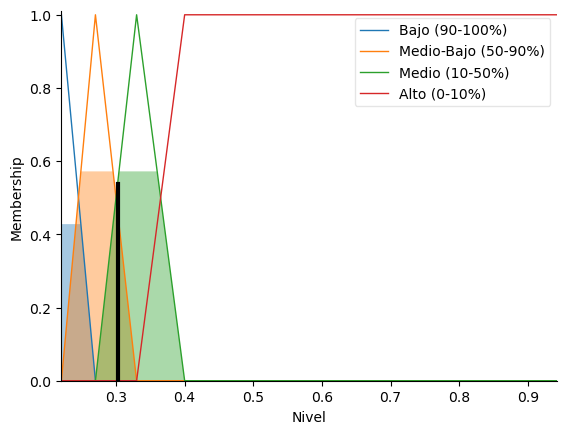

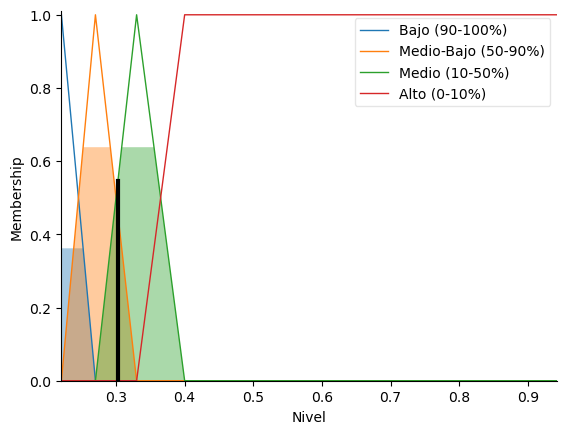

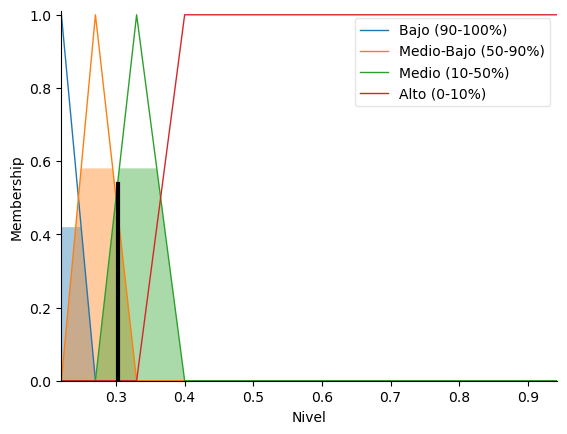

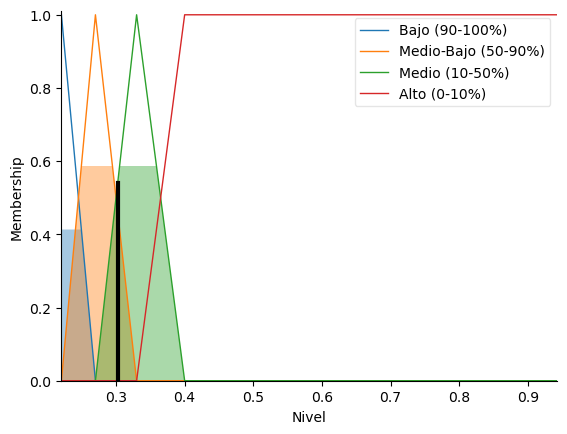

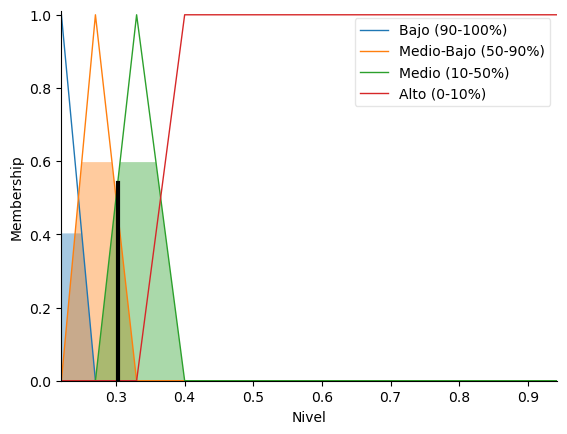

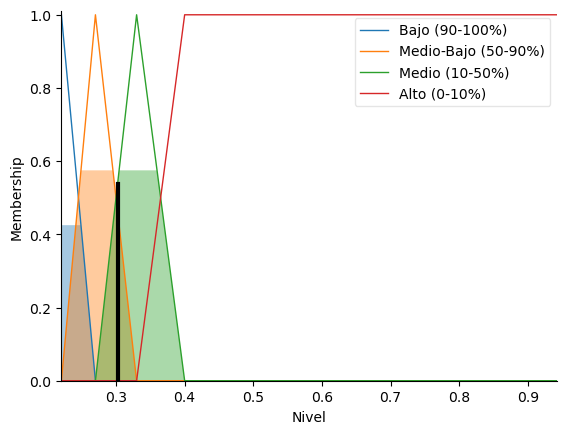

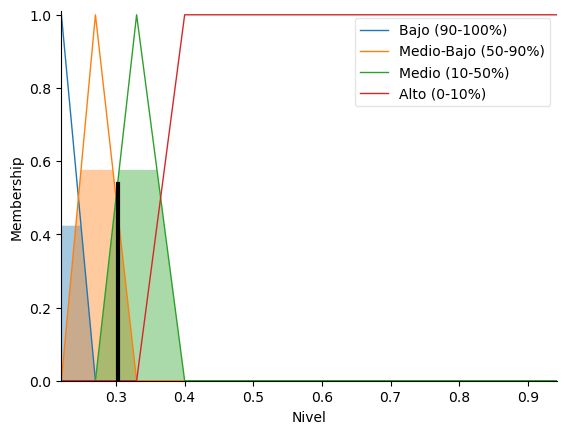

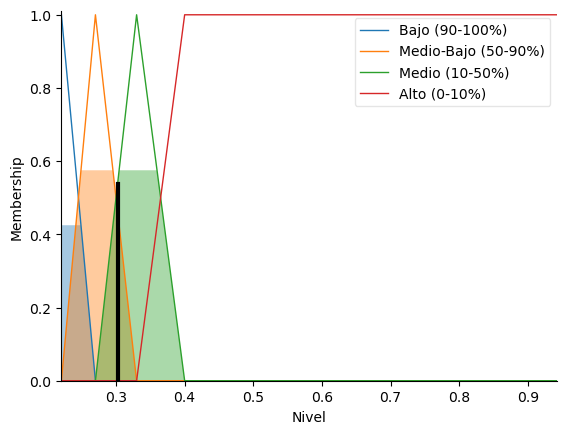

In [11]:
Pronostico_Precipitacion = pd.Series(dtype=float)
Pronostico_Temperatura = pd.Series(dtype=float)

DatosHistoricos, Estaciones, Percentiles = CDG()
DatosPrec = LeerArchivos("Precipitacion")
DatosTemp = LeerArchivos("Temperatura")
DatosNiv = LeerArchivos("Nivel")
EstP = ElegirEstacion(DatosPrec)
EstT = ElegirEstacion(DatosTemp)
EstN = ElegirEstacion(DatosNiv)
Pronostico_Precipitacion = Pron_PyT(DatosPrec, EstP, 'Precipitación')
Pronostico_Temperatura = Pron_PyT(DatosTemp, EstT, 'Temperatura')
Pronostico_Nivel = LogicaDifusa(DatosPrec, DatosTemp, DatosNiv)